# Model 1_1
## Dataset: tweet_emotions.csv from kaggle
https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text/data 

## Programmer: Giovanni Vecchione
## Date: 4/4/24
## Subject: Machine Learning 2 - Project 4
Use Recurrent Neural Networks(RNN)/LSTM/GRU or sentiment analysis to build the project. 
Submit your project as Jupyter notebook

Goal: LSTM model that can detect emotion from text

In [91]:
import tensorflow as tf
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from keras.regularizers import l1
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from sklearn.utils import class_weight
from tensorflow.keras import backend as K 
from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

seed = 42
random.seed(seed)

In [42]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [43]:
# Load the CSV into a pandas DataFrame
#change path if needed. In my case after extracting I have to state the csv file twice for some reason.
data = pd.read_csv(r'D:\GioDude\Documents\ACC\Spring 2024\Machine Learning II\Datasets\tweet_emotions_data\tweet_emotions.csv\tweet_emotions.csv')

# Check out the data
print(data.head())  # Print the first few rows to see its structure
print(data.shape)   # See dimensions: (number of rows, number of columns)

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...
(40000, 3)


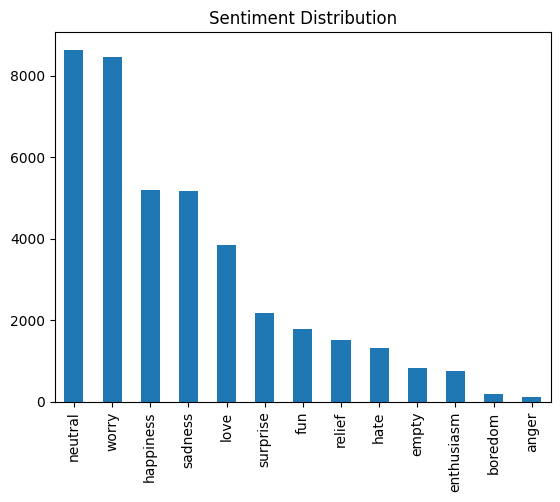

In [44]:
# Sentiment distribution
data['sentiment'].value_counts().plot(kind='bar') 
plt.title('Sentiment Distribution')
plt.show()

In [45]:
# Drop rows with missing 'content'
data.dropna(subset=['content'], inplace=True) 

# Drop rows with missing 'sentiment'
data.dropna(subset=['sentiment'], inplace=True) 

# Preprocessing:

In [46]:

def clean_tweet(tweet):
    # Remove punctuation, lowercase, etc. 
    tweet = re.sub(r'[^\w\s]', '', tweet)  
    tweet = tweet.lower() 
    return tweet

data['content'] = data['content'].apply(clean_tweet)

In [47]:
def tokenize_tweet(tweet):
    return tweet.split()  # Simple whitespace tokenization

data['content'] = data['content'].apply(tokenize_tweet)

In [48]:
from collections import Counter

def build_vocabulary(tweets, max_vocab_size=None):
    all_words = [word for tweet in tweets for word in tweet]
    word_counts = Counter(all_words)

    if max_vocab_size:
        vocab = word_counts.most_common(max_vocab_size) 
    else:
        vocab = word_counts.items() 

    word_to_index = {word: i for i, (word, count) in enumerate(vocab)}
    return word_to_index

vocab = build_vocabulary(data['content'], max_vocab_size=10000) # Limit to 10k words 

In [49]:
def encode_tweets(tweets, word_to_index):
    encoded_tweets = []
    for tweet in tweets:
        encoded_tweet = [word_to_index[word] for word in tweet if word in word_to_index]
        encoded_tweets.append(encoded_tweet)
    return encoded_tweets

#Encoded feature for X
X = encode_tweets(data['content'], vocab)

In [50]:
from keras.utils import to_categorical
# Encode the entire sentiment column
encoder = LabelEncoder()
y = encoder.fit_transform(data['sentiment']) # Assuming you've already fit a LabelEncoder
y = to_categorical(y)

#y is the target value

In [51]:
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(mapping) 


{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}


# Splitting Data:

In [52]:
# After your data cleaning and preprocessing steps ...
#Dataset is to be split 70/15/15 (this can be adjusted)


# Initial split: 70% training, 30% for further splitting 
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the temporary set into validation and testing: 50/50
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42, stratify=y_train_temp)

In [53]:
max_tweet_length = 50  # Adjust this based on your data 

X_train = pad_sequences(X_train, maxlen=max_tweet_length) 
X_val = pad_sequences(X_val, maxlen=max_tweet_length)
X_test = pad_sequences(X_test, maxlen=max_tweet_length)

In [84]:

vocab_size = len(vocab) # Size of character vocabulary
embedding_dim = 64    # Dimensionality of character embeddings
max_tweet_length = 50  # Adjust this based on data

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Larger embedding size
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = l2(0.001)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.LSTM(16, return_sequences=True),  
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(13, activation='softmax') 
])

In [100]:
model1_1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)] 

In [101]:
history1_1 = model1_1.fit(X_train, y_train, 
          epochs=15, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          callbacks=callbacks)

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.4621 - loss: 1.5503 - val_accuracy: 0.2779 - val_loss: 2.3441
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5104 - loss: 1.4615 - val_accuracy: 0.2770 - val_loss: 2.4438
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5379 - loss: 1.3886 - val_accuracy: 0.2721 - val_loss: 2.4780
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.5503 - loss: 1.3268 - val_accuracy: 0.2749 - val_loss: 2.5379
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5834 - loss: 1.2678 - val_accuracy: 0.2710 - val_loss: 2.6121
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6072 - loss: 1.2089 - val_accuracy: 0.2674 - val_loss: 2.6789


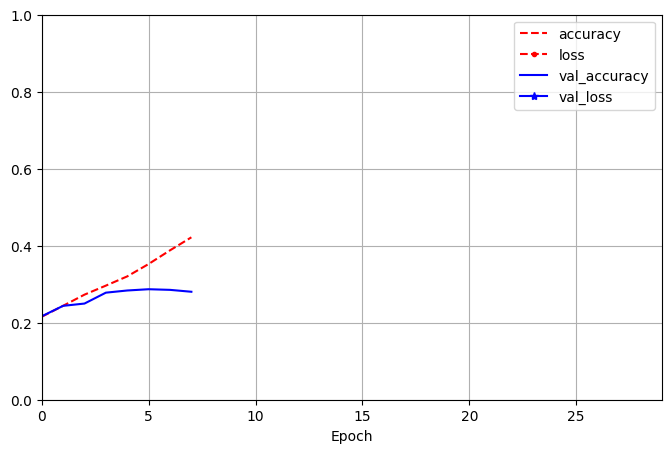

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history1_1.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

## Test #1:
### Implemented a simpleRNN layer to see if the model works.

#### Model Code:

vocab_size = len(vocab) # Size of character vocabulary
embedding_dim = 64    # Dimensionality of character embeddings
max_tweet_length = 50  # Adjust this based on data

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Masking(mask_value=0),  # Introduce a masking layer
    tf.keras.layers.SimpleRNN(units=64),  
    tf.keras.layers.Dense(13, activation='softmax')  
])

model1_1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### Results:
It seems that the model is up and running! However it seems that the model is overfitting to the training data as the validation data shows loss in performance while the training seems to continuously improve.



## Test #2
### Removing the simpleRNN layer and fully focusing on a LSTM model. Best to not mix the two layers to avoid the vanishing gradient issue.

#### Model Code:

vocab_size = len(vocab) # Size of character vocabulary
embedding_dim = 64    # Dimensionality of character embeddings
max_tweet_length = 50  # Adjust this based on data

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Larger embedding size
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # Using LSTM
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.LSTM(units=32),  # Stacked RNN
    tf.keras.layers.Dense(13, activation='softmax') 
])

model1_1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### Results:
The model seems to be performing better! However it is still overfitting. Validation loss is still high.




## Test #3:
### Added new dense layer with a L1 regularization to combat overfitting. Also added another dropout layer. Included early stopping aswell.

#### Model Code:
model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Larger embedding size
    tf.keras.layers.LSTM(64), 
    tf.keras.layers.Dropout(0.2),   # Existing dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l1(0.001)),  # L1 on Dense layer
    tf.keras.layers.Dropout(0.25),  # Another dropout
    tf.keras.layers.Dense(13, activation='softmax') 
])

model1_1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])


### Results:
It seems to have stopped the overfitting. However now the model is not finding the patterns. The accuracy and loss is performing poorly on both train and validation. This might be an improvement. 

## Test #4:
### Added another LSTM layer and reduced the L1 and dropout layers. This could help since it seems the model is now too simple to understand the underlying patterns.

This actually caused some errors. Turns out LSTMs don't return the right output unless specified.

## Test #5:
### Changed model to:

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Larger embedding size
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.LSTM(16, return_sequences=True),  
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(13, activation='softmax') 
])

### Results:
The deeper model helped with the overall accuracy. however the val_loss is not seeing any improvement. This indicates the deeper LSTM model is clearly learning better and making better predictions. The val_loss is either due to overfitting, learning rate is too high, or the optimizer may need to be changed.

## Test #5.1 - Address overfitting using regularizer L2

### Model Code:

vocab_size = len(vocab) # Size of character vocabulary
embedding_dim = 64    # Dimensionality of character embeddings
max_tweet_length = 50  # Adjust this based on data

model1_1 = Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Larger embedding size
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = l2(0.001)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.LSTM(16, return_sequences=True),  
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(13, activation='softmax') 
])



### Results:
So adding regularization did smooth the accuracy curve albeit not really improving. However loss is still very high.
    Epoch 8/15
    438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.4269 - loss: 1.6438 - val_accuracy: 0.2804 - val_loss: 2.2793

## Test #5.2 - Address the class imbalance by adding a wighted loss function

### Custom Loss Code:

#Create a custom_categorical_crossentropy function
#this will address the class imbalances

def weighted_custom_categorical_crossentropy(class_weights):
    """
    Weighted categorical crossentropy with a class weight parameter.

    Args:
        class_weights: A dictionary of class weights, with 
                       class indices as keys and weight values.
    """

    def loss_function(y_true, y_pred):
        # Normalize prediction to sum to 1 (like a probability distribution) 
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip to prevent excessively small values
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Convert class weights to a tensor 
        weights = K.constant(class_weights)

        # Expand dimensions of `weights` to match `y_true` shape
        weights = K.expand_dims(weights, axis=(0, 1)) 

        # Calculate weighted loss for each sample and sum over the axis
        loss = -(y_true * K.log(y_pred) * weights) 
        loss = K.sum(loss, axis=-1)

        return loss
    
    return loss_function


classes = np.unique(y_train).tolist()  # Convert to a list 

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=classes, 
                                                  y=y_train)  

class_weights_dict = dict(enumerate(class_weights)) 

### Results: INCOMPLETE
Although clearly the loss issue is due to the class imbalance, however with the alotted time frame I am unable to debug this portion for now. I will test other avenues to improve performance.